In [1]:
import pyspark
from pyspark.sql import SparkSession
#SparkSession is now the entry point of Spark
#SparkSession can also be construed as gateway to spark libraries

#create instance of spark class
spark=SparkSession.builder.appName('housing_price_model').getOrCreate()

#create spark dataframe of input csv file
df=spark.read.csv('/config/workspace/cruise_ship_info.csv'
				,inferSchema=True,header=True)
df.show(10)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/06 08:49:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/06 08:49:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/04/06 08:49:03 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/04/06 08:49:03 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Elation|   Carnival| 15|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Fantasy|   Carnival| 23| 

In [2]:
#prints structure of dataframe along with datatype
df.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [3]:
#In our predictive model, below are the columns
df.columns


['Ship_name',
 'Cruise_line',
 'Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'crew']

In [9]:
print(dict(df.dtypes)['crew'] )

double


In [10]:
for col in df.columns:
    print(f"{col} dtype : {dict(df.dtypes)[col]}" )
    print(f"{col} name : {df.select(col).distinct().count()}")

Ship_name dtype : string
Ship_name name : 138
Cruise_line dtype : string
Cruise_line name : 20
Age dtype : int
Age name : 31
Tonnage dtype : double
Tonnage name : 94
passengers dtype : double
passengers name : 104
length dtype : double
length name : 80
cabins dtype : double
cabins name : 98
passenger_density dtype : double
passenger_density name : 109
crew dtype : double
crew name : 91


In [4]:
#columns identified as features are as below:
#['Cruise_line','Age','Tonnage','passengers','length','cabins','passenger_density']
#to work on the features, spark MLlib expects every value to be in numeric form
#feature 'Cruise_line is string datatype
#using StringIndexer, string type will be typecast to numeric datatype
#import library strinindexer for typecasting

from pyspark.ml.feature import StringIndexer
indexer=StringIndexer(inputCol='Cruise_line',outputCol='cruise_cat')
indexed=indexer.fit(df).transform(df)

#above code will convert string to numeric feature and create a new dataframe
#new dataframe contains a new feature 'cruise_cat' and can be used further
#feature cruise_cat is now vectorized and can be used to fed to model
for item in indexed.head(5):
	print(item)
	print('\n')


Row(Ship_name='Journey', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55, cruise_cat=16.0)


Row(Ship_name='Quest', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55, cruise_cat=16.0)


Row(Ship_name='Celebration', Cruise_line='Carnival', Age=26, Tonnage=47.262, passengers=14.86, length=7.22, cabins=7.43, passenger_density=31.8, crew=6.7, cruise_cat=1.0)


Row(Ship_name='Conquest', Cruise_line='Carnival', Age=11, Tonnage=110.0, passengers=29.74, length=9.53, cabins=14.88, passenger_density=36.99, crew=19.1, cruise_cat=1.0)


Row(Ship_name='Destiny', Cruise_line='Carnival', Age=17, Tonnage=101.353, passengers=26.42, length=8.92, cabins=13.21, passenger_density=38.36, crew=10.0, cruise_cat=1.0)




In [11]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
#creating vectors from features
#Apache MLlib takes input if vector form
assembler=VectorAssembler(inputCols=['Age',
'Tonnage',
'passengers',
'length',
'cabins',
'passenger_density',
'cruise_cat'],outputCol='features')
output=assembler.transform(indexed)
output.select('features','crew').show(5)
#output as below


+--------------------+----+
|            features|crew|
+--------------------+----+
|[6.0,30.276999999...|3.55|
|[6.0,30.276999999...|3.55|
|[26.0,47.262,14.8...| 6.7|
|[11.0,110.0,29.74...|19.1|
|[17.0,101.353,26....|10.0|
+--------------------+----+
only showing top 5 rows



In [12]:
#final data consist of features and label which is crew.
final_data=output.select('features','crew')
#splitting data into train and test
train_data,test_data=final_data.randomSplit([0.7,0.3])
train_data.describe().show()


+-------+-----------------+
|summary|             crew|
+-------+-----------------+
|  count|              105|
|   mean|7.885428571428579|
| stddev|3.718629045498082|
|    min|             0.59|
|    max|             21.0|
+-------+-----------------+



In [13]:
test_data.describe().show()


+-------+------------------+
|summary|              crew|
+-------+------------------+
|  count|                53|
|   mean| 7.613396226415093|
| stddev|3.0582303476383617|
|    min|              0.59|
|    max|             12.38|
+-------+------------------+



In [32]:
#import LinearRegression library
from pyspark.ml.regression import LinearRegression
#creating an object of class LinearRegression
#object takes features and label as input arguments
LinReg=LinearRegression(featuresCol='features',labelCol='crew')
#pass train_data to train model
model=ship_lr.fit(train_data)
#evaluating model trained for Rsquared error
pred=model.evaluate(test_data)
pred.predictions.show()

#print('Rsquared Error :',ship_results.r2)
#R2 value shows accuracy of model is 92%
#model accuracy is very good and can be use for predictive analysis


23/04/06 09:47:42 WARN Instrumentation: [7ed5f174] regParam is zero, which might cause numerical instability and overfitting.


+--------------------+-----+------------------+
|            features| crew|        prediction|
+--------------------+-----+------------------+
|[5.0,86.0,21.04,9...|  8.0|  9.17188845336096|
|[6.0,30.276999999...| 3.55| 4.123983970112089|
|[6.0,93.0,23.94,9...|11.09|10.468096052163578|
|[6.0,110.23899999...| 11.5|11.412815486633065|
|[6.0,112.0,38.0,9...| 10.9|11.616966783181365|
|[9.0,88.5,21.24,9...| 10.3| 9.497047053447822|
|[9.0,113.0,26.74,...|12.38| 11.17448552723307|
|[9.0,113.0,26.74,...|12.38| 11.17448552723307|
|[9.0,116.0,26.0,9...| 11.0|10.957223665774794|
|[10.0,81.76899999...| 8.42| 8.733591454007207|
|[10.0,90.09,25.01...| 8.58| 9.020620781237064|
|[11.0,90.09,25.01...| 8.48|  9.01862482102656|
|[11.0,91.0,20.32,...| 9.99| 9.147576983141775|
|[11.0,91.62700000...|  9.0| 9.104037957147224|
|[11.0,108.977,26....| 12.0|10.948273887336608|
|[12.0,2.329,0.94,...|  0.6|0.2334921547532538|
|[12.0,25.0,3.88,5...| 2.87|2.9868182184451326|
|[12.0,42.0,14.8,7...|  6.8| 6.641867098

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [34]:

#Find out coefficient value
coefficient = model.coefficients
print ("The coefficient of the model is : %a" %coefficient)


#Find out intercept Value
intercept = model.intercept
print ("The Intercept of the model is : %f" %intercept)

#Evaluate the model using metric like Mean Absolute Error(MAE), Root Mean Square Error(RMSE) and R-Square
from pyspark.ml.evaluation import RegressionEvaluator
evaluation = RegressionEvaluator(labelCol="crew", predictionCol="prediction")

# Root Mean Square Error
rmse = evaluation.evaluate(pred.predictions, {evaluation.metricName: "rmse"})
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = evaluation.evaluate(pred.predictions, {evaluation.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = evaluation.evaluate(pred.predictions, {evaluation.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = evaluation.evaluate(pred.predictions, {evaluation.metricName: "r2"})
print("r2: %.3f" %r2)


The coefficient of the model is : DenseVector([-0.002, -0.0001, -0.0811, 0.4768, 0.776, 0.0043, 0.0465])
The Intercept of the model is : -1.811751
RMSE: 0.791
MSE: 0.625
MAE: 0.603
r2: 0.932


In [35]:
#testing Model on unlabeled data
#create unlabeled data from test_data
#testing model on unlabeled data
unlabeled_data=test_data.select('features')
unlabeled_data.show(5)


+--------------------+
|            features|
+--------------------+
|[5.0,86.0,21.04,9...|
|[6.0,30.276999999...|
|[6.0,93.0,23.94,9...|
|[6.0,110.23899999...|
|[6.0,112.0,38.0,9...|
+--------------------+
only showing top 5 rows



In [36]:
predictions=model.transform(unlabeled_data)
predictions.show()
#below are the results of output from test data


+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[5.0,86.0,21.04,9...|  9.17188845336096|
|[6.0,30.276999999...| 4.123983970112089|
|[6.0,93.0,23.94,9...|10.468096052163578|
|[6.0,110.23899999...|11.412815486633065|
|[6.0,112.0,38.0,9...|11.616966783181365|
|[9.0,88.5,21.24,9...| 9.497047053447822|
|[9.0,113.0,26.74,...| 11.17448552723307|
|[9.0,113.0,26.74,...| 11.17448552723307|
|[9.0,116.0,26.0,9...|10.957223665774794|
|[10.0,81.76899999...| 8.733591454007207|
|[10.0,90.09,25.01...| 9.020620781237064|
|[11.0,90.09,25.01...|  9.01862482102656|
|[11.0,91.0,20.32,...| 9.147576983141775|
|[11.0,91.62700000...| 9.104037957147224|
|[11.0,108.977,26....|10.948273887336608|
|[12.0,2.329,0.94,...|0.2334921547532538|
|[12.0,25.0,3.88,5...|2.9868182184451326|
|[12.0,42.0,14.8,7...| 6.641867098964483|
|[12.0,91.0,20.32,...| 9.145581022931271|
|[13.0,61.0,13.8,7...| 6.424151818676919|
+--------------------+------------

In [42]:
trainingSummary = model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 1.023754
r2: 0.923479


In [44]:
model.summary.rootMeanSquaredError

1.0237539676940104

In [45]:
from pyspark.ml.regression import FMRegressor
fmr = FMRegressor(labelCol="crew", stepSize=0.001)

model = fmr.fit(train_data)
print(model) 
 
print("Coefficients: ", model.linear)
print("Intercept: ", model.intercept)

FMRegressionModel: uid=FMRegressor_b7155668e0fc, numFeatures=7, factorSize=8, fitLinear=true, fitIntercept=true
Coefficients:  [0.01476536076009994,0.01356568960379443,0.016479287344704753,0.017427791732310037,0.01839195630318457,0.013168484847419134,0.005042634976918416]
Intercept:  0.01711178428657885


In [47]:
tdata = model.transform(test_data)
tdata.show(3)

rmse = RegressionEvaluator(labelCol="crew", predictionCol="prediction", metricName="rmse")
rmse = rmse.evaluate(tdata)
mae = RegressionEvaluator(labelCol="crew", predictionCol="prediction", metricName="mae")
mae = mae.evaluate(tdata)
r2 = RegressionEvaluator(labelCol="crew", predictionCol="prediction", metricName="r2")
r2 = r2.evaluate(tdata)

print("Coefficients: ", model.linear)
print("Intercept: ", model.intercept)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R-squared: ", r2)

+--------------------+-----+------------------+
|            features| crew|        prediction|
+--------------------+-----+------------------+
|[5.0,86.0,21.04,9...|  8.0| 7.182907713183299|
|[6.0,30.276999999...| 3.55|3.1014809169728936|
|[6.0,93.0,23.94,9...|11.09| 8.216082327318542|
+--------------------+-----+------------------+
only showing top 3 rows

Coefficients:  [0.01476536076009994,0.01356568960379443,0.016479287344704753,0.017427791732310037,0.01839195630318457,0.013168484847419134,0.005042634976918416]
Intercept:  0.01711178428657885
RMSE:  1.324479924446674
MAE:  1.0017858610764891
R-squared:  0.8088286096799251


In [ ]:
The coefficient of the model is : DenseVector([-0.002, -0.0001, -0.0811, 0.4768, 0.776, 0.0043, 0.0465])
The Intercept of the model is : -1.811751
RMSE: 0.791
MSE: 0.625
MAE: 0.603
r2: 0.932

In [49]:
import matplotlib.pyplot as plt

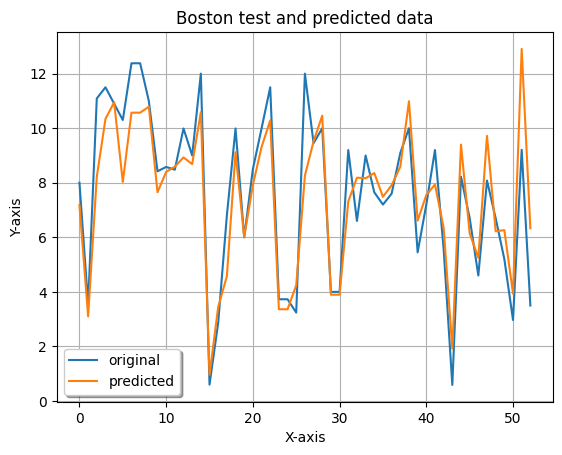

In [51]:
plt.Figure(figsize=(15,15))
x_ax = range(0, tdata.count())
y_pred=tdata.select("prediction").collect()
y_orig=tdata.select("crew").collect()
 
plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Boston test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

In [ ]:
from pyspark.ml.regression import FMRegressor
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn.datasets import load_boston
import pandas as pd
import matplotlib.pyplot as plt

boston = load_boston()
df_boston = pd.DataFrame(boston.data,columns=boston.feature_names)
df_boston['target'] = pd.Series(boston.target)
print(df_boston.head())

sc = SparkContext().getOrCreate()
sqlContext = SQLContext(sc)

data = sqlContext.createDataFrame(df_boston)
print(data.printSchema())

features = boston.feature_names.tolist()

va = VectorAssembler(inputCols = features, outputCol='features')

va_df = va.transform(data)
va_df = va_df.select(['features', 'target'])
va_df.show(3)

(train, test) = va_df.randomSplit([0.8, 0.2])

fmr = FMRegressor(labelCol="target", stepSize=0.001)

model = fmr.fit(train)
print(model)

print("Coefficients: ", model.linear)
print("Intercept: ", model.intercept)

tdata = model.transform(test)
tdata.show(3)

rmse = RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="rmse")
rmse = rmse.evaluate(tdata)
mae = RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="mae")
mae = mae.evaluate(tdata)
r2 = RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="r2")
r2 = r2.evaluate(tdata)

print("RMSE: ", rmse)
print("MAE: ", mae)
print("R-squared: ", r2)

x_ax = range(0, tdata.count())
y_pred=tdata.select("prediction").collect()
y_orig=tdata.select("target").collect()

plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Boston test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

sc.stop() 
 